In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from tqdm import trange, tqdm
import yaml
%matplotlib notebook
import warnings
warnings.filterwarnings(action='once')
from datetime import datetime

import torch
from torch_geometric.nn import radius
from torch_geometric.nn import SplineConv, fps, global_mean_pool, radius_graph, radius
from torch_scatter import scatter

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from config import *
from plotting import *
from compressible import compressibleSimulation
from incompressible import incompressibleSimulation
from scenarios import *
from solidBC import *


In [2]:
# s = 1
# a = s **2  / config['targetNeighbors'] * np.pi
# r = np.sqrt(a / np.pi)
# print(r)

In [40]:
def getILConfig(radius = 0.23360679774997896, dt = 0.005, c = .2, device = 'cpu', precision = torch.float64):

    config = {
        'radius': radius,
        'targetNeighbors': 20,
        'restDensity': 1000,
        'dt': dt,
        'kappa':1.5,
        'viscosityConstant':0.1,
        'max_neighbors':256,
#         'device':'cpu',
    #     'device':device,
#         'precision': torch.float32,
        'precision': precision,
        'device':device,
        
        'domain':{
            'periodicX':True,
            'periodicY':True,
            'min': [-5, -5],
            'max': [5,5],
            'buffer': 2
        }
#         ,
#         'solidBoundary':[
#             {
#                 'vertices': [[-1,-1],[1,-1],[1,1],[-1,1]],
#                 'inverted': False
#             }
#         ]
    }
    config['maxValue'] = torch.finfo(config['precision']).max

    config['area'] = np.pi * config['radius']**2
    config['support'] = np.sqrt(config['area'] / np.pi * config['targetNeighbors'])

    config['packing'] = minimize(lambda x: evalPacking(x,config), 0.5, method="nelder-mead").x[0]
    config['spacing'] = -minimize(lambda x: evalSpacing(x,config), 0., method="nelder-mead").x[0]
    
    D = (config['domain']['max'][1] - config['domain']['min'][1])
    spacing = config['spacing']
    packing = config['packing']
    n = int(np.ceil((D / config['support'] - 2 * spacing)/packing))
    h = D / (2 * spacing + n * packing)
    area = h**2 / config['targetNeighbors'] * np.pi
    radius = np.sqrt(area / np.pi)
#     print(D, spacing, packing, n, h, area, radius)
    
    config['radius'] = radius
    config['area'] = area
    config['support'] = h
    
    p = config['packing'] * config['support']
    nx = int(np.ceil((config['domain']['max'][0] - config['domain']['min'][0]) / p))
    ny = int(np.ceil((config['domain']['max'][1] - config['domain']['min'][1]) / p))
#     print('nx', nx)
#     print('prior', config['domain']['max'][0])
    config['domain']['max'][0] = config['domain']['min'][0] + nx * p
    config['domain']['max'][1] = config['domain']['min'][1] + ny * p
#     print('after', config['domain']['max'][0])

    minDomain = config['domain']['min']
    maxDomain = config['domain']['max']
#     print(config['domain']['min'], config['domain']['max'])
    
    config['emitters'] = [
#         {
#         'min': overallDomainMin + spacing * np.array([0,0]),
#         'max': overallDomainMin + spacing * np.array([toDomain[0]+ 1,toMin[1]]),
#         'compression': 1.5
#     },{
#         'min': overallDomainMin + spacing * np.array([0,toMax[1]]),
#         'max': overallDomainMin + spacing * np.array([toDomain[0] + 1,toDomain[1]+ 1]),
#         'compression': 1.5
#     }
#         ,{
#         'min': overallDomainMin + spacing * np.array([0,toMin[1] + 1]),
#         'max': overallDomainMin + spacing * np.array([toMin[0],toMax[1]-1]),
#         'compression': 1.5
#     }    
#     ,{
#         'min': overallDomainMin + spacing * np.array([toMax[0]+1,toMin[1] + 1]),
#         'max': overallDomainMin + spacing * np.array([toDomain[0]+1,toMax[1]-1]),
#         'compression': 1.5
#     }
#         ,
#         {
#         'min': overallDomainMin + spacing * np.array([toMin[0],toMin[1]]),
#         'max': overallDomainMin + spacing * np.array([toMax[0],toMax[1]]),
#         'compression': 3.0
#     }
        {
        'min': minDomain + p / 2,
        'max': maxDomain - p / 2,
        'compression': 1.0
    }
    ]


    for emitter in config['emitters']:
        if 'radius' not in emitter:
            emitter['radius'] = config['radius']
        if 'density' not in emitter:
            emitter['density'] = config['restDensity']
        if 'type' not in emitter:
            emitter['type'] = 'once'
        if 'compression' not in emitter:
            emitter['compression'] = 1.0
        if 'velocity' not in emitter:
            emitter['velocity'] = [0.0,0.0]

    if 'gravity' not in config:
        config['gravity'] = [0,0]


    minCompression = config['maxValue']
    for emitter in config['emitters']:
        minCompression = min(minCompression, emitter['compression'])
    config['minCompression'] = minCompression

    config['domain']['virtualMin'] = config['domain']['min']
    config['domain']['virtualMax'] = config['domain']['max']
    config['domain']['min'] = config['domain']['min'] - config['domain']['buffer'] * config['support']
    config['domain']['max'] = config['domain']['max'] + config['domain']['buffer'] * config['support']
    
    addBoundaryBoundaries(config)
    if 'solidBoundary' in config:
        for boundary in config['solidBoundary']:
            boundary['polygon'] = torch.tensor(boundary['vertices'], device = config['device'], dtype = config['precision'])
        
    return config

In [41]:
def getVelocityXY(config, simulationState, nx = 256, ny = 256):
    xx,yy,uv = getUVs(simulationState['fluidVelocity'], config, simulationState, nx,ny)
    data = np.linalg.norm(uv,axis=2)
    return data
def getVelocityScatter(config, simulationState):
    return simulationState['fluidPosition'].detach().cpu().numpy(), \
        np.linalg.norm(simulationState['fluidVelocity'].detach().cpu().numpy(), axis = 1)

xyPlotFn = lambda config, state, nx, ny: getVelocityXY(config, state, nx = 256, ny = 256)
scatterPlotFn = lambda config, state: getVelocityScatter(config, state)


In [42]:
def getDensityXY(config, simulationState, nx = 256, ny = 256):
    xx,yy,uv = getUVs(simulationState['fluidDensity'], config, simulationState, nx,ny)
#     data = np.linalg.norm(uv,axis=2)
    return uv

def getDensityScatter(config, simulationState):
    return simulationState['fluidPosition'].detach().cpu().numpy(), \
        simulationState['fluidDensity'].detach().cpu().numpy()


In [43]:
from periodicBC import *
from neighborhood import *
from sph import *

<IPython.core.display.Javascript object>


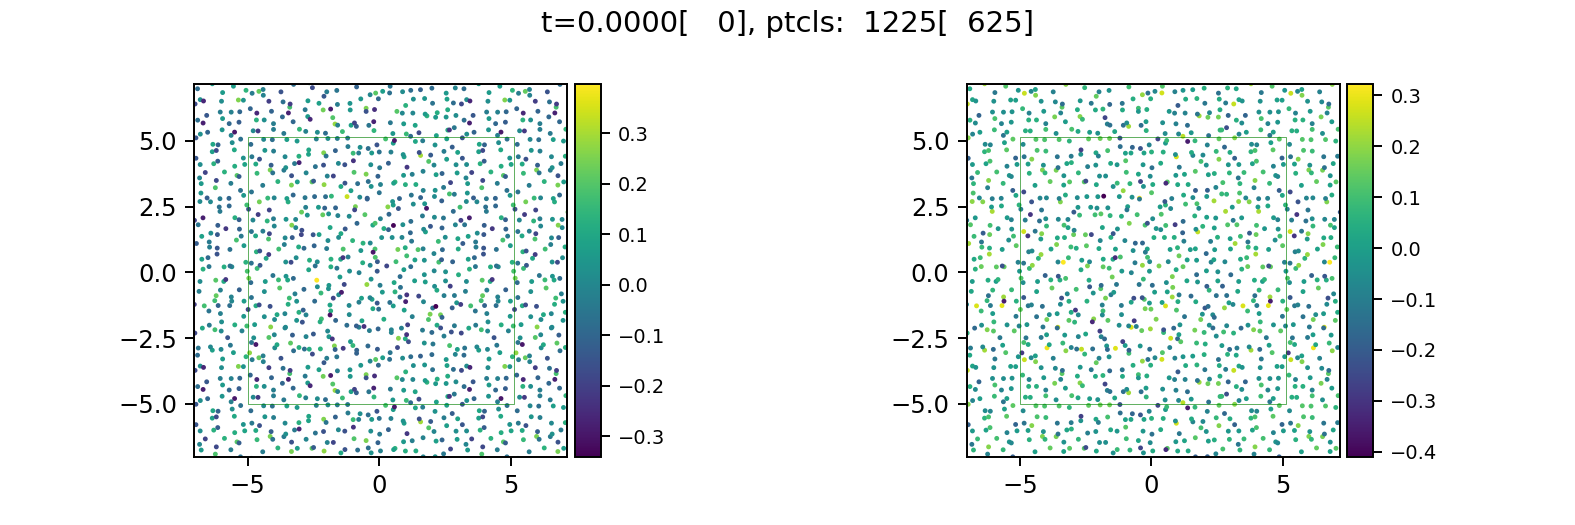

<IPython.core.display.Javascript object>


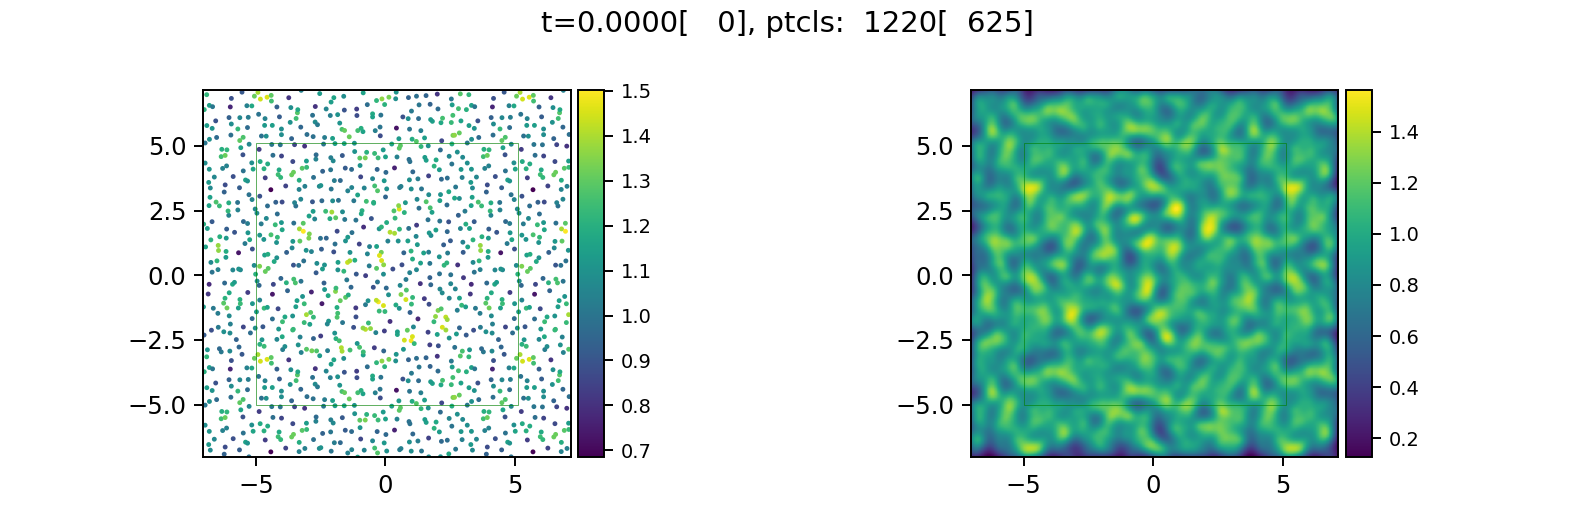

In [44]:
config = getILConfig()
simFn = lambda config, state: compressibleSimulation(config, state)

state = initializeSimulation(config)
enforcePeriodicBC(config, state)

jitter = torch.normal(torch.zeros(state['fluidPosition'].shape, device = config['device'], dtype=config['precision']))\
        * config['support'] / 8
syncQuantity(jitter, config, state)
state['fluidPosition'] += jitter


def getJitterX(config, simulationState):
    return simulationState['fluidPosition'].detach().cpu().numpy(), \
        jitter[:,0].detach().cpu().numpy()
def getJitterY(config, simulationState):
    return simulationState['fluidPosition'].detach().cpu().numpy(), \
        jitter[:,1].detach().cpu().numpy()


fig, im, axis, cbar = initialPlot(config, state,[getJitterX, getJitterY], 256, 256, figsize=(9,3), plotLayout = (1,2))

enforcePeriodicBC(config, state)

state['fluidNeighbors'], state['fluidDistances'], state['fluidRadialDistances'] = \
    neighborSearch(state['fluidPosition'], state['fluidPosition'], config, state)

state['fluidDensity'] = sphDensity(config, state)  

fig, im, axis, cbar = initialPlot(config, state,[getDensityScatter, getDensityXY], 256, 256, figsize=(9,3), plotLayout = (1,2))

In [47]:
def getUVs(qty, config, simulationState, nx = 256, ny = 256):
    x = np.linspace(config['domain']['min'][0],config['domain']['max'][0],nx)
    y = np.linspace(config['domain']['min'][1],config['domain']['max'][1],ny)
                              
    xx, yy = np.meshgrid(x, y)

    xf = xx.flatten()
    yf = yy.flatten()

    gridPositions = torch.from_numpy(np.c_[xf, yf]).type(config['precision']).to(config['device'])

    row, col = radius(simulationState['fluidPosition'], gridPositions, config['support'], max_num_neighbors = config['max_neighbors'])
    edge_index = torch.stack([row, col], dim = 0)
        
    j = edge_index[1]
    i = edge_index[0]

    pseudo = (simulationState['fluidPosition'][j] - gridPositions[i])    
    q = torch.linalg.norm(pseudo,axis=1) / config['support']
    
    kernel = wendland(q, config['support'])
    factor = kernel * simulationState['fluidArea'][j] / simulationState['fluidDensity'][j]
    if len(qty.shape) > 1:
        term = factor[:,None] * qty[j]
    else:
        term = factor * qty[j]
#     print(term.shape)
    
    out = scatter(term, i, dim=0, dim_size=gridPositions.size(0), reduce="add")

#     out = torch.tensor(gridPositions)
#     out = gridPositions[:,0]
    
    if len(qty.shape) > 1:
        uv = out.detach().cpu().numpy().reshape(ny,nx,qty.shape[1])
    else:
        uv = out.detach().cpu().numpy().reshape(ny,nx,1)

    return xx,yy,uv

<IPython.core.display.Javascript object>


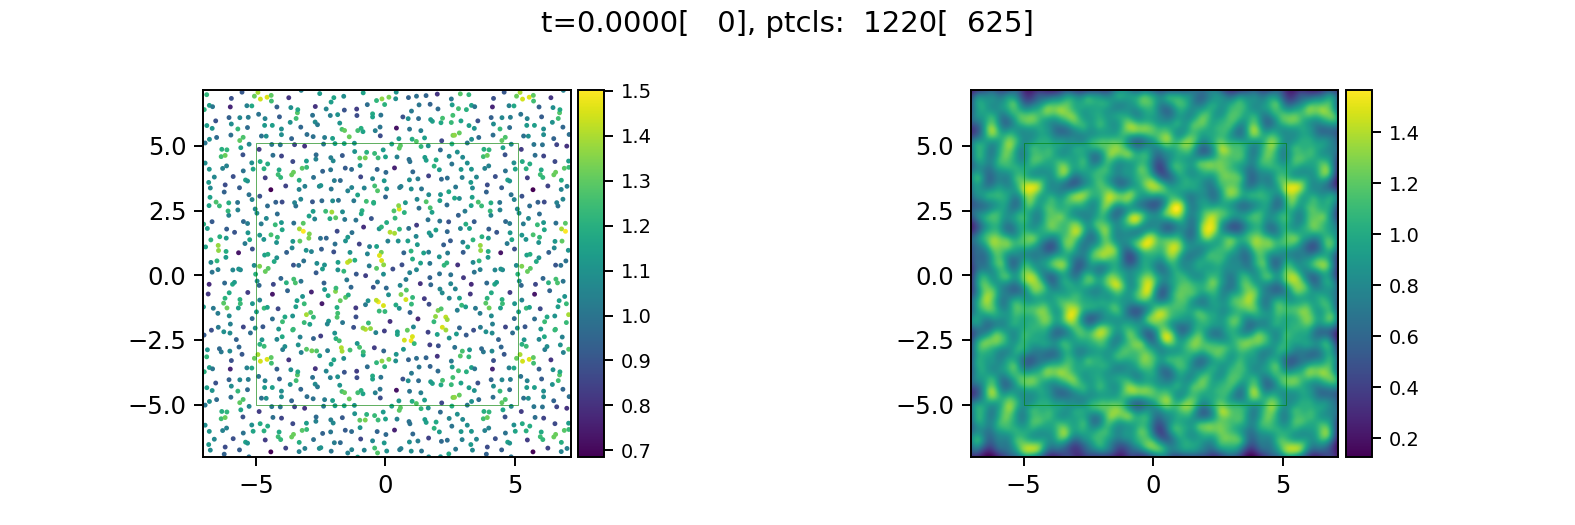

In [46]:
def getDensityXY(config, simulationState, nx = 256, ny = 256):
    xx,yy,uv = getUVs(simulationState['fluidDensity'], config, simulationState, nx,ny)
#     data = np.linalg.norm(uv,axis=2)
    return uv

fig, im, axis, cbar = initialPlot(config, state,[getDensityScatter, getDensityXY], 512, 512, figsize=(9,3), plotLayout = (1,2))

In [48]:
from kernel import *

In [49]:
def w2(config, state, reduce = True):
    neighbors = state['fluidNeighbors']
    i = neighbors[1]
    j = neighbors[0]
    fluidRadialDistances = state['fluidRadialDistances']
    
    k  = wendland(fluidRadialDistances, config['support'])
    if reduce:
        s = scatter(k, i, dim=0, dim_size=state['numParticles'], reduce="add")
        syncQuantity(s, config, state)
        return s
    return k

In [50]:
def firstDerivative(config, state, reduce = True):
    d = -state['fluidDistances']
    r =  state['fluidRadialDistances']
    
    neighbors = state['fluidNeighbors']
#     print(neighbors.shape)
    i = neighbors[1]
    j = neighbors[0]
    
    support = config['support']
    
    a = state['fluidPosition'][i]
    b = state['fluidPosition'][j]
    
    df = d.flatten().reshape(d.shape[0] * d.shape[1])
    rf = r.flatten()
    qf = rf / support
    
    x_a = a[:,0]
    x = b[:,0]
    y_a = a[:,1]
    y = b[:,1]
    
    l = torch.sqrt((x_a - x)**2 + (y_a - y)**2).flatten()
    q = l / support
    dx = (x_a - x).flatten()
    dy = (y_a - y).flatten()
    
    df = torch.zeros((dx.shape[0],2), dtype=dx.dtype, device = dx.device)
#     print(a)
#     print('x_a', x_a.shape)
#     print('x', x.shape)
#     print('dx', dx.shape)
#     print('dy', dy.shape)
#     print('l', l.shape)
#     print('df',df.shape)

    c = 7. / np.pi
    h = support
    
    df[:,0] = -(20 * c * (h **(-7))* (dx) *pow(l -h, 3)).flatten()
    df[:,1] = -(20 * c * (h **(-7))* (dy) *pow(l -h, 3)).flatten()
    
    df[q>1,0] = 0
    df[q>1,1] = 0
    if reduce:
        df = scatter(df, i, dim = 0, dim_size = state['numParticles'], reduce= "add")
        syncQuantity(df, config, state)

        return df
    return df

firstDerivative(config, state)
    

tensor([[-5.3689, -0.9901],
        [-3.7937, -0.2575],
        [ 1.2147, -0.2879],
        ...,
        [ 5.4561,  7.5909],
        [-4.8064, -7.6056],
        [-5.5670,  4.6870]], dtype=torch.float64)

In [51]:
def secondDerivative(config, state, reduce = True):
    d = -state['fluidDistances']
    r =  state['fluidRadialDistances']
    
    neighbors = state['fluidNeighbors']
    support = config['support']
#     print(neighbors.shape)
    i = neighbors[1]
    j = neighbors[0]
    
    a = state['fluidPosition'][i]
    b = state['fluidPosition'][j]
    
    df = d.flatten().reshape(d.shape[0] * d.shape[1])
    rf = r.flatten()
    qf = rf / support
    
    x_a = a[:,0]
    x = b[:,0]
    y_a = a[:,1]
    y = b[:,1]
    
    
#     df[:,0,0] = 1.
    
    c = 7. / np.pi
    h = support
    
    l = torch.sqrt((x_a - x)**2 + (y_a - y)**2).flatten()
    q = l / support
    dx = (x_a - x).flatten()
    dy = (y_a - y).flatten()
    
    df = torch.zeros((dx.shape[0],2,2), device = dx.device, dtype=dx.dtype)
    
    
    df[:,0,0] = 20 * c / h**7 * (l - h)**3
    
    df[l>0,0,0] -= (60 * c / h**7 * (l-h)**2 * dx * -dx)[l>0] / l[l>0]
    
    df[l>0,0,1] = - (60 * c / h**7 * -dx*dy * (l - h)**2)[l>0] / l[l>0]
    df[:,1,0] = df[:,0,1]
    
    df[:,1,1] = 20 * c / h**7 * (l - h)**3
    df[l>0,1,1] -= (60 * c / h**7 * (l-h)**2 * -dy * dy)[l>0] / l[l>0]
    
    df[q>1,:,:] = 0.
    
    if reduce:
        df = scatter(df, i, dim = 0, dim_size = state['numParticles'], reduce= "add")
        syncQuantity(df, config, state)

        return df
    return df
secondDerivative(config, state)

tensor([[[-20.0083,   7.8405],
         [  7.8405, -29.2887]],

        [[-39.5212,  -6.5077],
         [ -6.5077, -25.4401]],

        [[-14.2230, -16.4004],
         [-16.4004, -11.2230]],

        ...,

        [[-55.6245,  -3.5641],
         [ -3.5641, -44.1052]],

        [[-13.7893,  10.3551],
         [ 10.3551, -40.6445]],

        [[-48.3673,   8.4496],
         [  8.4496, -30.1683]]], dtype=torch.float64)

In [52]:
def plotToGrid(data, axis):
    d = torch.clone(data)
    l = int(np.ceil(np.sqrt(data.shape[0])))
    l2 = l**2
#     padShape = d.shape
    padShape = l2 - d.shape[0]
    pad = torch.ones(padShape, device = d.device, dtype=d.dtype)  * torch.nan
    d = torch.cat((d,pad))
    d = d.reshape(l,l,-1)
    im = axis.imshow(d)
    ax1_divider = make_axes_locatable(axis)
    cax1 = ax1_divider.append_axes("right", size="7%", pad="2%")
    plt.colorbar(im, cax=cax1)

In [53]:
state['fluidOmegas'] = config['area'] / state['fluidDensity']

In [105]:
# def evalKernel(config, state, reduce = True):
#     if reduce:
#         k = w2(config, state, reduce = True)
#         J = state['fluidOmegas'][:,None] * firstDerivative(config, state, reduce = True)
#         H = state['fluidOmegas'][:,None,None] * secondDerivative(config, state, reduce = True)
#     else:
#         j = state['fluidNeighbors'][0]
#         i = state['fluidNeighbors'][1]
#         k = w2(config, state, reduce = False)
#         J = state['fluidOmegas'][j,None] * firstDerivative(config, state, reduce = False)
#         H = state['fluidOmegas'][j,None,None] * secondDerivative(config, state, reduce = False)
#     return k, J, H


# fig, axis = plt.subplots(4,2, 
#     constrained_layout=True, figsize=(6,9),
#     gridspec_kw={
#         "height_ratios": [1,1,1,1],
#         "width_ratios": [1, 1],
#     },sharey = True, sharex = True)

# gs = axis[0, 0].get_gridspec()
# # remove the underlying axes
# axis[0,0].remove()
# axis[0,1].remove()
# axbig = fig.add_subplot(gs[0, 0:])

# k, J, H = evalKernel(config, state)

# i = 0

# # plotToGrid(k[i,:], axbig)

# # plotToGrid(J[i,:,0], axis[1,0])
# # plotToGrid(J[i,:,1], axis[1,1])A

# # plotToGrid(H[i,:,0,0], axis[2,0])
# # plotToGrid(H[i,:,0,1], axis[2,1])
# # plotToGrid(H[i,:,1,0], axis[3,0])
# # plotToGrid(H[i,:,1,1], axis[3,1])

# plotToGrid(k, axbig)
# axbig.set_title('Kernel Function')

# plotToGrid(J[:,0], axis[1,0])
# plotToGrid(J[:,1], axis[1,1])
# axis[1,0].set_title('∇Kernel.x')
# axis[1,1].set_title('∇Kernel.y')

# plotToGrid(H[:,0,0], axis[2,0])
# plotToGrid(H[:,0,1], axis[2,1])
# plotToGrid(H[:,1,0], axis[3,0])
# plotToGrid(H[:,1,1], axis[3,1])
# axis[2,0].set_title('∇²Kernel.xx')
# axis[2,1].set_title('∇²Kernel.xy')
# axis[3,0].set_title('∇²Kernel.yx')
# axis[3,1].set_title('∇²Kernel.yy')

# # fig.tight_layout()


In [55]:
def solveShifting(config, state):
    K, J, H = evalKernel(config, state, reduce = False)

    JJ = scatter(J, state['fluidNeighbors'][1], dim=0, dim_size=state['numParticles'], reduce= "add")

    B = torch.zeros(JJ.shape[0]*2, device = JJ.device, dtype=JJ.dtype)
    B[::2] = JJ[:,0]
    B[1::2] = JJ[:,1]


    A = torch.zeros(state['numParticles'] * 2, state['numParticles']*2, device = K.device, dtype = K.dtype)

    neighbors = state['fluidNeighbors']
    support = config['support']
    i = neighbors[1]
    j = neighbors[0]

    A[2*i,2*j] = H[:,0,0]
    A[2*i+1,2*j] = H[:,1,0]
    A[2*i,2*j+1] = H[:,0,1]
    A[2*i+1,2*j+1] = H[:,1,1]

    diff = torch.linalg.solve(A,B)

    dx = torch.zeros(J.shape[0], device = J.device, dtype=J.dtype)
    dy = torch.zeros(J.shape[0], device = J.device, dtype=J.dtype)
    dx = -diff[::2]
    dy = -diff[1::2]

    update = torch.vstack((dx,dy)).T
    syncQuantity(update, config, state)

    state['fluidUpdate'] = update


In [87]:
K, J, H = evalKernel(config, state, reduce = False)

JJ = scatter(J, state['fluidNeighbors'][1], dim=0, dim_size=state['numParticles'], reduce= "add")

B = torch.zeros(JJ.shape[0]*2, device = JJ.device, dtype=JJ.dtype)
B[::2] = JJ[:,0]
B[1::2] = JJ[:,1]


A = torch.zeros(state['numParticles'] * 2, state['numParticles']*2, device = K.device, dtype = K.dtype)

neighbors = state['fluidNeighbors']
support = config['support']
i = neighbors[1]
j = neighbors[0]

A[2*i,2*j] = H[:,0,0]
A[2*i+1,2*j] = H[:,1,0]
A[2*i,2*j+1] = H[:,0,1]
A[2*i+1,2*j+1] = H[:,1,1]

diff = torch.linalg.solve(A,B)

dx = torch.zeros(J.shape[0], device = J.device, dtype=J.dtype)
dy = torch.zeros(J.shape[0], device = J.device, dtype=J.dtype)
dx = -diff[::2]
dy = -diff[1::2]

update = torch.vstack((dx,dy)).T
syncQuantity(update, config, state)

state['fluidUpdate'] = update


In [88]:
i = state['fluidNeighbors'][1]
j = state['fluidNeighbors'][0]

diagonal = i == j
nondiagonal = i != j

print(i[i==j].shape)
print(i.shape)

torch.Size([1220])
torch.Size([22528])


In [58]:
# D = torch.diag(A)
# R = A - torch.diagflat(D)

# # x = torch.rand(state['numParticles'] * 2, device = config['device'], dtype=config['precision'])
# x = torch.linalg.solve(A,B) * 2
# for i in range(16):
#     x = (B - torch.matmul(R,x)) / D
#     print(torch.mean(B - torch.matmul(R,x)))
# print(x)

In [59]:
torch.sum(torch.sum(torch.abs(R),axis=0) < torch.abs(D))

tensor(6)

In [60]:
x = torch.linalg.solve(A,B)

In [68]:
def LinearCG(A, b, x0, tol=1e-5):
    xk = x0
    rk = np.dot(A, xk) - b
    pk = -rk
    rk_norm = np.linalg.norm(rk)
    
    num_iter = 0
    curve_x = [xk]
    while rk_norm > tol:
        apk = np.dot(A, pk)
        rkrk = np.dot(rk, rk)
        print(apk.shape, apk)
        print(rkrk.shape, rkrk)
        
        alpha = rkrk / np.dot(pk, apk)
        xk = xk + alpha * pk
        rk = rk + alpha * apk
        beta = np.dot(rk, rk) / rkrk
        pk = -rk + beta * pk
        
        num_iter += 1
        curve_x.append(xk)
        rk_norm = np.linalg.norm(rk)
        print('Iteration: {} \t x = {} \t residual = {:.4f}'.
              format(num_iter, xk, rk_norm))
    
    print('\nSolution: \t x = {}'.format(xk))
        
    return np.array(curve_x)

In [69]:
x0 = torch.rand(state['numParticles'] * 2, device = config['device'], dtype=config['precision'])
xsol = LinearCG(A.detach().numpy(), B.detach().numpy(), x0.detach().numpy())

(2440,) [ -3.52692536  54.17371881 -38.56006294 ...   2.38255562   7.35522013
 -37.84076575]
() 26190.224607449516
Iteration: 1 	 x = [ 0.24992353  0.37724561 -0.02445896 ...  0.26938318  0.53796502
  0.24360336] 	 residual = 75.2132
(2440,) [ -6.45476879 -24.8072258    7.84468116 ...  -9.0382817   -6.94065969
 -14.64739951]
() 5657.020825597403
Iteration: 2 	 x = [ 0.10226777  0.01211891  0.01302668 ...  0.00731463  0.25701648
 -0.18293198] 	 residual = 37.2689
(2440,) [-0.9750192  -1.04799781 -3.36296706 ... -4.50430476 -5.16387776
  0.70025441]
() 1388.9732340576604
Iteration: 3 	 x = [ 0.07517461 -0.05790221  0.01065228 ... -0.10286181  0.08055416
 -0.26172488] 	 residual = 17.6586
(2440,) [ 1.28667662  0.92314042  2.41885261 ... -0.41793209 -1.54349076
  0.06345041]
() 311.82591819800894
Iteration: 4 	 x = [ 0.09092834 -0.04443109  0.05262108 ... -0.10817716  0.00740139
 -0.27289493] 	 residual = 8.9964
(2440,) [ 0.60389387  0.17902342  0.47352684 ...  1.4065365  -1.0670044
  0.84

In [75]:
update = xsol[-1]
xsol = np.zeros_like(state['fluidPosition'].detach().cpu().numpy())
xsol[:,0] = update[::2]
xsol[:,1] = update[1::2]

<IPython.core.display.Javascript object>


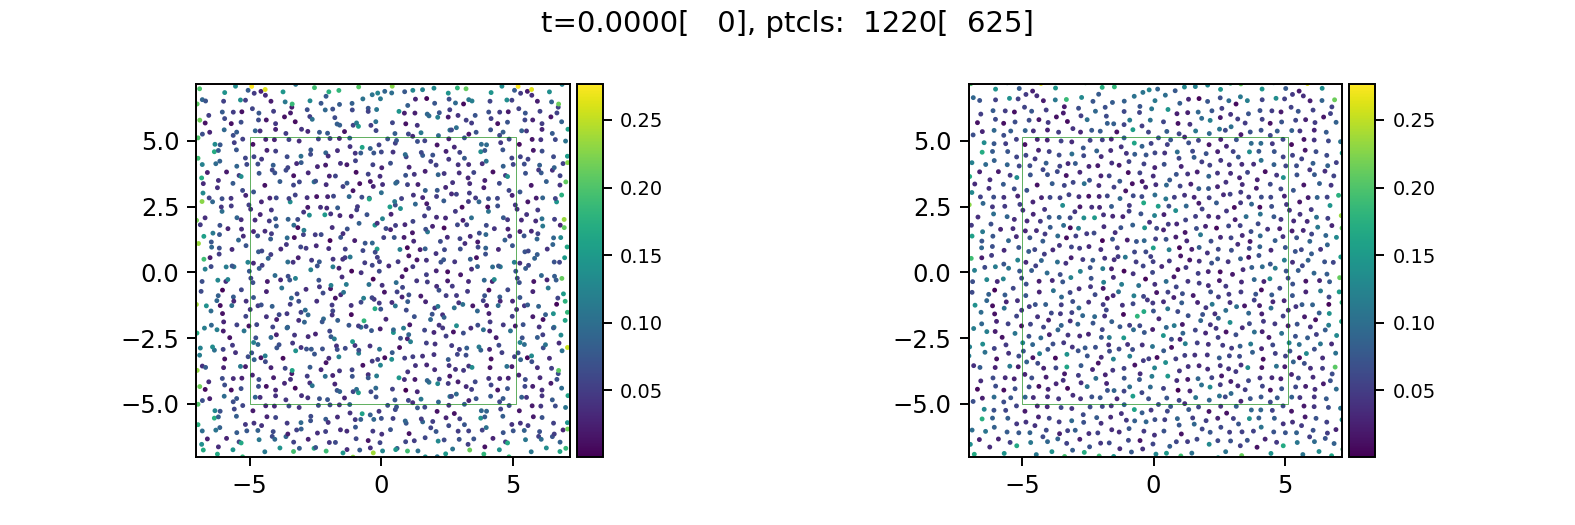

In [77]:
def getUpdateScatterX(config, simulationState):
    return simulationState['fluidPosition'].detach().cpu().numpy(), \
        np.linalg.norm(xsol, axis = 1)
def getUpdateScatterY(config, simulationState):
    return simulationState['fluidPosition'].detach().cpu().numpy() - xsol, \
        np.linalg.norm(xsol, axis = 1)

fig, im, axis, cbar = initialPlot(config, state,[getUpdateScatterX, getUpdateScatterY], 256, 256, figsize=(9,3), plotLayout = (1,2))

In [103]:
def LinearCG(H, B, x0, tol=1e-5):    
    xk = x0
    rk = torch.zeros(state['numParticles'] * 2, device = config['device'], dtype=config['precision'])

    rk[::2]  += scatter(H[:,0,0] * xk[j * 2], i, dim=0, dim_size=state['numParticles'], reduce= "add")
    rk[::2]  += scatter(H[:,0,1] * xk[j * 2 + 1], i, dim=0, dim_size=state['numParticles'], reduce= "add")

    rk[1::2] += scatter(H[:,1,0] * xk[j * 2], i, dim=0, dim_size=state['numParticles'], reduce= "add")
    rk[1::2] += scatter(H[:,1,1] * xk[j * 2 + 1], i, dim=0, dim_size=state['numParticles'], reduce= "add")
    
    rk = rk - B
    
    pk = -rk
    rk_norm = torch.linalg.norm(rk)
    
    num_iter = 0
    while rk_norm > tol:
        apk = torch.zeros(state['numParticles'] * 2, device = config['device'], dtype=config['precision'])

        apk[::2]  += scatter(H[:,0,0] * pk[j * 2], i, dim=0, dim_size=state['numParticles'], reduce= "add")
        apk[::2]  += scatter(H[:,0,1] * pk[j * 2 + 1], i, dim=0, dim_size=state['numParticles'], reduce= "add")

        apk[1::2] += scatter(H[:,1,0] * pk[j * 2], i, dim=0, dim_size=state['numParticles'], reduce= "add")
        apk[1::2] += scatter(H[:,1,1] * pk[j * 2 + 1], i, dim=0, dim_size=state['numParticles'], reduce= "add")

        rkrk = torch.dot(rk, rk)
        
        alpha = rkrk / torch.dot(pk, apk)
        xk = xk + alpha * pk
        rk = rk + alpha * apk
        beta = torch.dot(rk, rk) / rkrk
        pk = -rk + beta * pk
        
        num_iter += 1

        rk_norm = torch.linalg.norm(rk)
    return xk

B = torch.zeros(JJ.shape[0]*2, device = JJ.device, dtype=JJ.dtype)
B[::2] = JJ[:,0]
B[1::2] = JJ[:,1]
xsol = LinearCG(H, B,x0)

In [104]:
def solveShifting(config, state):
    K, J, H = evalKernel(config, state, reduce = False)

    JJ = scatter(J, state['fluidNeighbors'][1], dim=0, dim_size=state['numParticles'], reduce= "add")
    B = torch.zeros(JJ.shape[0]*2, device = JJ.device, dtype=JJ.dtype)
    B[::2] = JJ[:,0]
    B[1::2] = JJ[:,1]
    xsol = LinearCG(H,B, x0)
    update = torch.zeros(state['fluidPosition'].shape, device=config['device'], dtype=config['precision'])
    update[:,0] = xsol[::2]
    update[:,1] = xsol[1::2]
    
    syncQuantity(update, config, state)

    state['fluidUpdate'] = update


In [95]:
print(xsol)

tensor([ 0.0893, -0.0024,  0.0640,  ..., -0.0778, -0.0208, -0.2752],
       dtype=torch.float64)


In [98]:
x0 = torch.rand(state['numParticles'] * 2, device = config['device'], dtype=config['precision'])
xsol = LinearCG(H,JJ,x0)
x = torch.zeros(state['fluidPosition'].shape)
x[:,0] = xsol[0::2]
x[:,1] = xsol[1::2]
xsol = x

<IPython.core.display.Javascript object>


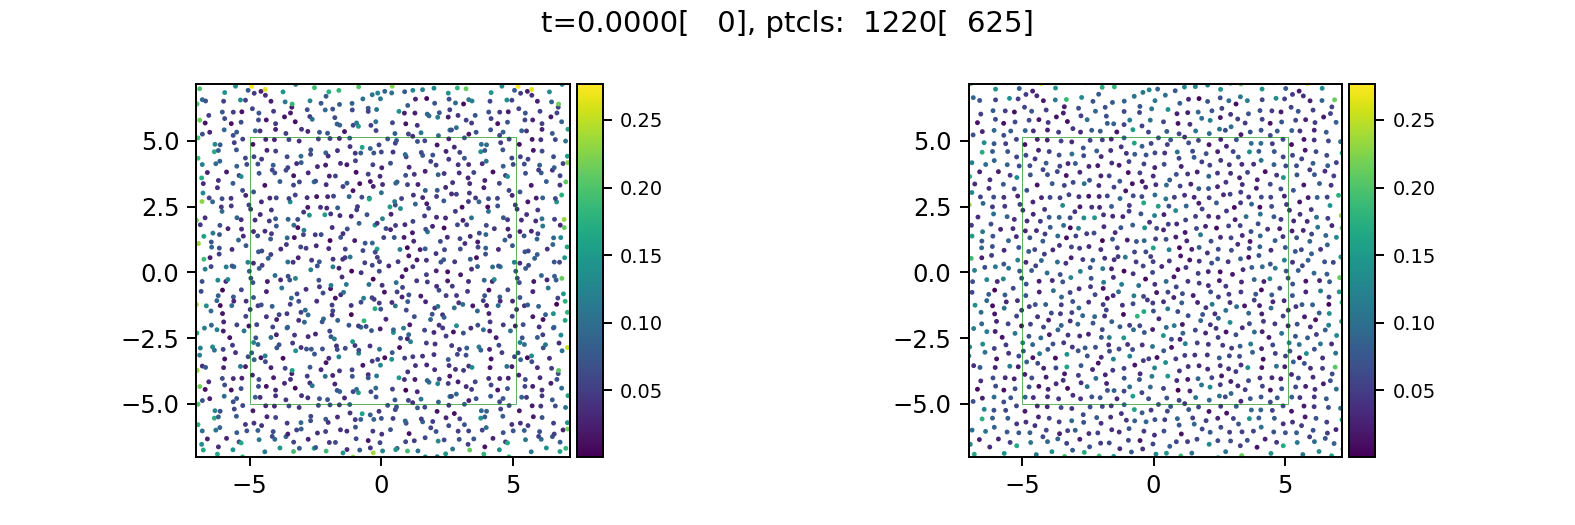

In [97]:
def getUpdateScatterX(config, simulationState):
    return simulationState['fluidPosition'].detach().cpu().numpy(), \
        np.linalg.norm(xsol, axis = 1)
def getUpdateScatterY(config, simulationState):
    return (simulationState['fluidPosition'] - xsol).detach().cpu().numpy(), \
        np.linalg.norm(xsol, axis = 1)

fig, im, axis, cbar = initialPlot(config, state,[getUpdateScatterX, getUpdateScatterY], 256, 256, figsize=(9,3), plotLayout = (1,2))

In [39]:
print(xsol)

tensor([-2.2165e-07, -1.0700e-07, -5.9685e-09,  ...,  2.8245e-08,
         4.0061e-09, -4.4905e-08], dtype=torch.float64)


In [416]:
x0 = torch.rand(state['numParticles'] * 2, device = config['device'], dtype=config['precision'])
K, J, H = evalKernel(config, state, reduce = False)

JJ = scatter(J, state['fluidNeighbors'][1], dim=0, dim_size=state['numParticles'], reduce= "add")
aii = torch.zeros(state['numParticles'] * 2, device = config['device'], dtype=config['precision'])
aii[::2] = H[diagonal,0,0]
aii[1::2] = H[diagonal,1,1]

JJ = scatter(J, state['fluidNeighbors'][1], dim=0, dim_size=state['numParticles'], reduce= "add")

B = torch.zeros(JJ.shape[0]*2, device = JJ.device, dtype=JJ.dtype)
B[::2] = JJ[:,0]
B[1::2] = JJ[:,1]

In [420]:

apk = torch.zeros(state['numParticles'] * 2, device = config['device'], dtype=config['precision'])

apk[::2]  += scatter(H[:,0,0] * x1[j * 2], i, dim=0, dim_size=state['numParticles'], reduce= "add")
apk[::2]  += scatter(H[:,0,1] * x1[j * 2 + 1], i, dim=0, dim_size=state['numParticles'], reduce= "add")

apk[1::2] += scatter(H[:,1,0] * x1[j * 2], i, dim=0, dim_size=state['numParticles'], reduce= "add")
apk[1::2] += scatter(H[:,1,1] * x1[j * 2 + 1], i, dim=0, dim_size=state['numParticles'], reduce= "add")

In [423]:
torch.sum(torch.matmul(A, x1) - apk)

tensor(8.9928e-15, dtype=torch.float64)

In [418]:
H[:,0,0] * x1[j * 2]

tensor([-12.0290,   2.1831,   2.1780,  ...,  -5.8933,   5.1514,  -1.1813],
       dtype=torch.float64)

In [383]:
x1 = torch.clone(x0)
x1 *= 0
errors = []
for ii in tqdm(range(16)):
#     K, J, H = evalKernel(config, state, reduce = False)
#     JJ = scatter(J, state['fluidNeighbors'][1], dim=0, dim_size=state['numParticles'], reduce= "add")
#     aii = torch.zeros(state['numParticles'] * 2, device = config['device'], dtype=config['precision'])
#     aii[::2] = H[diagonal,0,0]
#     aii[1::2] = H[diagonal,1,1]

#     JJ = scatter(J, state['fluidNeighbors'][1], dim=0, dim_size=state['numParticles'], reduce= "add")

#     B = torch.zeros(JJ.shape[0]*2, device = JJ.device, dtype=JJ.dtype)
#     B[::2] = JJ[:,0]
#     B[1::2] = JJ[:,1]
    
    aij = torch.zeros(state['numParticles'] * 2, device = config['device'], dtype=config['precision'])

    aij[::2]  += scatter(H[nondiagonal,0,0] * x1[j[nondiagonal] * 2], i[nondiagonal], dim=0, dim_size=state['numParticles'], reduce= "add")
    aij[::2]  += scatter(H[:,0,1] * x1[j * 2 + 1], i, dim=0, dim_size=state['numParticles'], reduce= "add")

    aij[1::2] += scatter(H[:,1,0] * x1[j * 2], i, dim=0, dim_size=state['numParticles'], reduce= "add")
    aij[1::2] += scatter(H[nondiagonal,1,1] * x1[j[nondiagonal] * 2 + 1], i[nondiagonal], dim=0, dim_size=state['numParticles'], reduce= "add")

    residual = B - aij
    omega = 2/3
    x1 = x1 + omega / aii * residual
    print(ii, torch.mean(residual))
    errors.append(-residual)
aij = torch.zeros(state['numParticles'] * 2, device = config['device'], dtype=config['precision'])

aij[::2]  += scatter(H[nondiagonal,0,0] * x1[j[nondiagonal] * 2], i[nondiagonal], dim=0, dim_size=state['numParticles'], reduce= "add")
aij[::2]  += scatter(H[:,0,1] * x1[j * 2 + 1], i, dim=0, dim_size=state['numParticles'], reduce= "add")

aij[1::2] += scatter(H[:,1,0] * x1[j * 2], i, dim=0, dim_size=state['numParticles'], reduce= "add")
aij[1::2] += scatter(H[nondiagonal,1,1] * x1[j[nondiagonal] * 2 + 1], i[nondiagonal], dim=0, dim_size=state['numParticles'], reduce= "add")


  0%|          | 0/16 [00:00<?, ?it/s]

0 tensor(0.0022, dtype=torch.float64)
1 tensor(-0.0027, dtype=torch.float64)
2 tensor(-0.0023, dtype=torch.float64)
3 tensor(-0.0008, dtype=torch.float64)
4 tensor(0.0010, dtype=torch.float64)
5 tensor(0.0030, dtype=torch.float64)
6 tensor(0.0055, dtype=torch.float64)
7 tensor(0.0087, dtype=torch.float64)
8 tensor(0.0129, dtype=torch.float64)
9 tensor(0.0185, dtype=torch.float64)
10 tensor(0.0261, dtype=torch.float64)
11 tensor(0.0367, dtype=torch.float64)
12 tensor(0.0513, dtype=torch.float64)
13 tensor(0.0719, dtype=torch.float64)
14 tensor(0.1009, dtype=torch.float64)
15 tensor(0.1420, dtype=torch.float64)


In [367]:
nondiag = A - A * torch.eye(state['numParticles'] * 2,state['numParticles'] * 2,device=config['device'], dtype=config['precision'])
aij_ref = nondiag.matmul(x1)

print(aij)
print(aij_ref)
print(torch.mean(aij - aij_ref))

tensor([  94.1901,  -22.2131,   85.4698,  ...,   38.4257, -202.0573,
         -49.2036], dtype=torch.float64)
tensor([  94.1901,  -22.2131,   85.4698,  ...,   38.4257, -202.0573,
         -49.2036], dtype=torch.float64)
tensor(9.7483e-18, dtype=torch.float64)


tensor([ 0.3134,  0.6295, -0.0100,  ...,  0.4638, -0.0144,  0.4803],
       dtype=torch.float64) tensor(1.1274, dtype=torch.float64)


In [212]:
oldPositions = torch.clone(state['fluidPosition'])

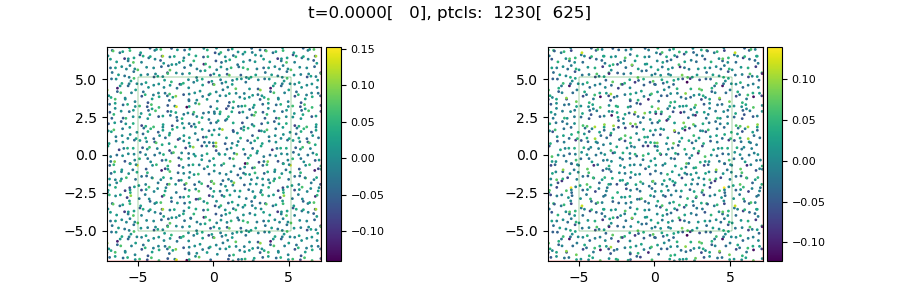

In [213]:
solveShifting(config, state)
def getUpdateScatterX(config, simulationState):
    return simulationState['fluidPosition'].detach().cpu().numpy(), \
        simulationState['fluidUpdate'][:,0].detach().cpu().numpy()
def getUpdateScatterY(config, simulationState):
    return simulationState['fluidPosition'].detach().cpu().numpy(), \
        simulationState['fluidUpdate'][:,1].detach().cpu().numpy()

fig, im, axis, cbar = initialPlot(config, state,[getUpdateScatterX, getUpdateScatterY], 256, 256, figsize=(9,3), plotLayout = (1,2))

In [193]:
# solveShifting(config,state)
# state['fluidPosition'] += state['fluidUpdate']

# enforcePeriodicBC(config, state)

# state['fluidNeighbors'], state['fluidDistances'], state['fluidRadialDistances'] = \
#     neighborSearch(state['fluidPosition'], state['fluidPosition'], config, state)

# state['fluidDensity'] = sphDensity(config, state)  

In [194]:
# def evalKernel(config, state, reduce = True):
#     if reduce:
#         k = w2(config, state, reduce = True)
#         J = state['fluidOmegas'][:,None] * firstDerivative(config, state, reduce = True)
#         H = state['fluidOmegas'][:,None,None] * secondDerivative(config, state, reduce = True)
#     else:
#         j = state['fluidNeighbors'][0]
#         i = state['fluidNeighbors'][1]
#         k = w2(config, state, reduce = False)
#         J = state['fluidOmegas'][j,None] * firstDerivative(config, state, reduce = False)
#         H = state['fluidOmegas'][j,None,None] * secondDerivative(config, state, reduce = False)
#     return k, J, H


# fig, axis = plt.subplots(4,2, 
#     constrained_layout=True, figsize=(6,9),
#     gridspec_kw={
#         "height_ratios": [1,1,1,1],
#         "width_ratios": [1, 1],
#     },sharey = True, sharex = True)

# gs = axis[0, 0].get_gridspec()
# # remove the underlying axes
# axis[0,0].remove()
# axis[0,1].remove()
# axbig = fig.add_subplot(gs[0, 0:])

# k, J, H = evalKernel(config, state)

# i = 0

# # plotToGrid(k[i,:], axbig)

# # plotToGrid(J[i,:,0], axis[1,0])
# # plotToGrid(J[i,:,1], axis[1,1])A

# # plotToGrid(H[i,:,0,0], axis[2,0])
# # plotToGrid(H[i,:,0,1], axis[2,1])
# # plotToGrid(H[i,:,1,0], axis[3,0])
# # plotToGrid(H[i,:,1,1], axis[3,1])

# plotToGrid(k, axbig)
# axbig.set_title('Kernel Function')

# plotToGrid(J[:,0], axis[1,0])
# plotToGrid(J[:,1], axis[1,1])
# axis[1,0].set_title('∇Kernel.x')
# axis[1,1].set_title('∇Kernel.y')

# plotToGrid(H[:,0,0], axis[2,0])
# plotToGrid(H[:,0,1], axis[2,1])
# plotToGrid(H[:,1,0], axis[3,0])
# plotToGrid(H[:,1,1], axis[3,1])
# axis[2,0].set_title('∇²Kernel.xx')
# axis[2,1].set_title('∇²Kernel.xy')
# axis[3,0].set_title('∇²Kernel.yx')
# axis[3,1].set_title('∇²Kernel.yy')

# fig.tight_layout()


<IPython.core.display.Javascript object>


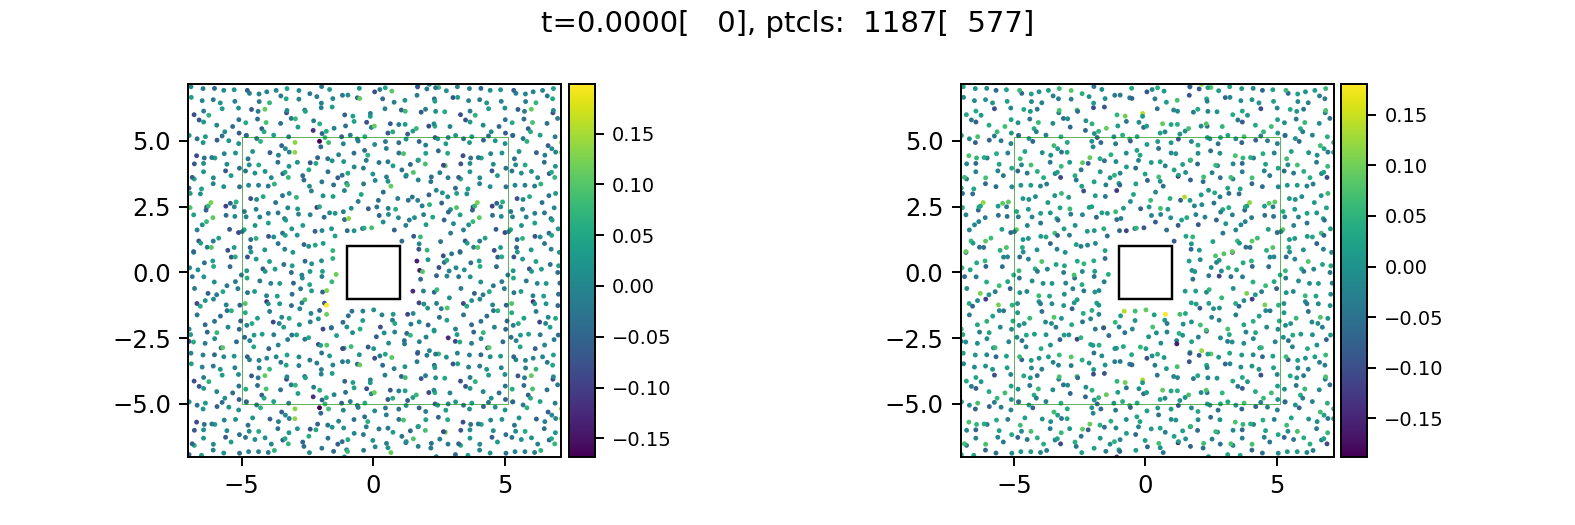

In [196]:
for i in tqdm(range(64)):
    solveShifting(config,state)
    state['fluidPosition'] += state['fluidUpdate']

    enforcePeriodicBC(config, state)

    state['fluidNeighbors'], state['fluidDistances'], state['fluidRadialDistances'] = \
        neighborSearch(state['fluidPosition'], state['fluidPosition'], config, state)

    state['fluidDensity'] = sphDensity(config, state)  
    updatePlot(config, state, fig, axis, im, cbar, [getUpdateScatterX, getUpdateScatterY], 256, 256)

  0%|          | 0/64 [00:00<?, ?it/s]

KeyboardInterrupt: 